In [1]:
import warnings
warnings.filterwarnings('ignore')

# Model fitting 3:  External Compton 

## Loading data

In [2]:
from jetset.jet_model import Jet
from jetset.data_loader import Data,ObsData
from jetset.test_data_helper import  test_SEDs
test_SEDs


['/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_3C345.ecsv',
 '/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv',
 '/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_ABS.ecsv',
 '/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_DEABS.ecsv']

In [3]:
data=Data.from_file(test_SEDs[0])


In [4]:
sed_data=ObsData(data_table=data)

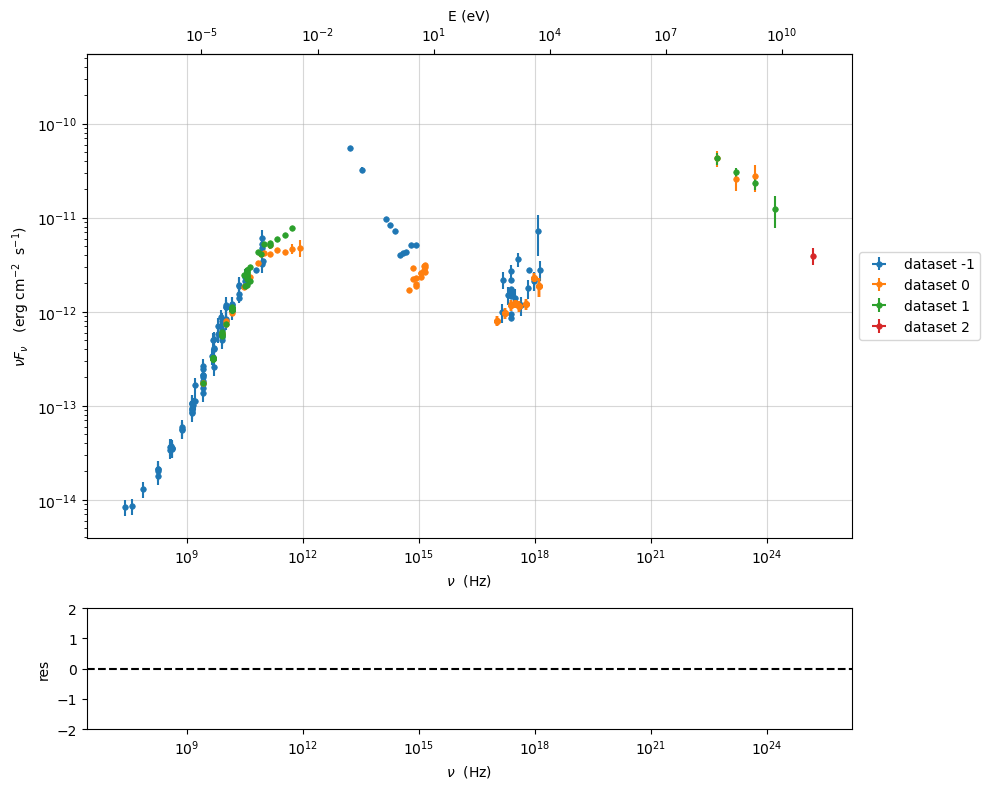

In [5]:
%matplotlib inline
p=sed_data.plot_sed(show_dataset=True)

we filter out the data set `-1` 

current datasets
dataset -1
dataset 0
dataset 1
dataset 2
---> excluding  data_set/s ['-1']
filter -1 192
current datasets
dataset 0
dataset 1
dataset 2
---> data sets left after filtering None
---> data len after filtering=192
---> excluding  data_set/s ['2']
filter 2 191
current datasets
dataset 0
dataset 1
---> data sets left after filtering None
---> data len after filtering=191
current datasets
dataset 0
dataset 1


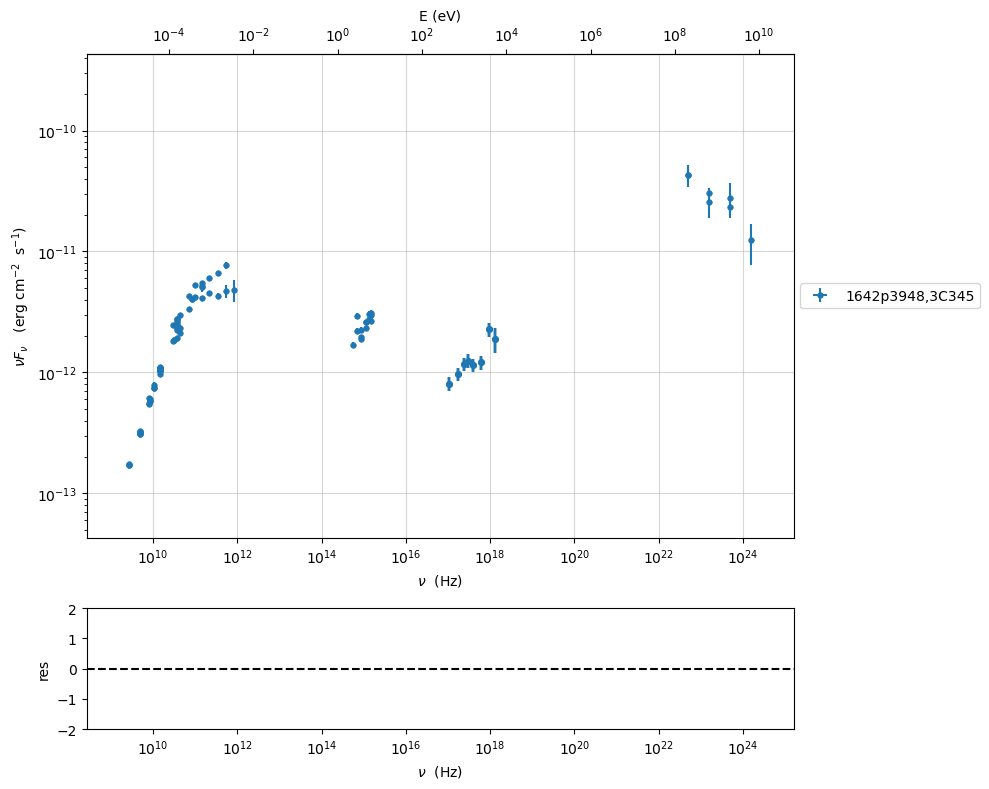

In [6]:
sed_data.show_data_sets()
sed_data.filter_data_set('-1',exclude=True)
sed_data.filter_data_set('2',exclude=True)
sed_data.show_data_sets()
p=sed_data.plot_sed()



***  binning data  ***
---> N bins= 100
---> bin_widht= 0.15



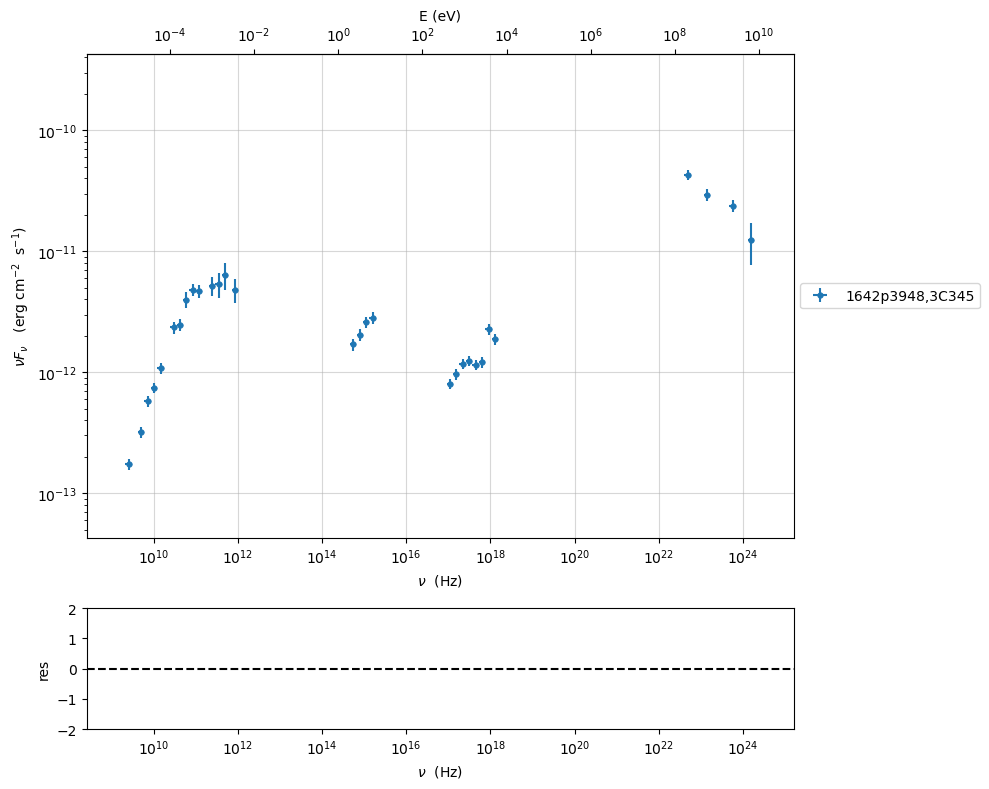

In [7]:
sed_data.group_data(bin_width=.15)
sed_data.add_systematics(0.1,[10.**6,10.**29])
#sed_data.add_systematics(0.05,[10.**19,10.**30])

p=sed_data.plot_sed()

In [8]:
sed_data.save('3C454_data.pkl')

## Phenomenological model constraining


*** evaluating spectral indices for data ***



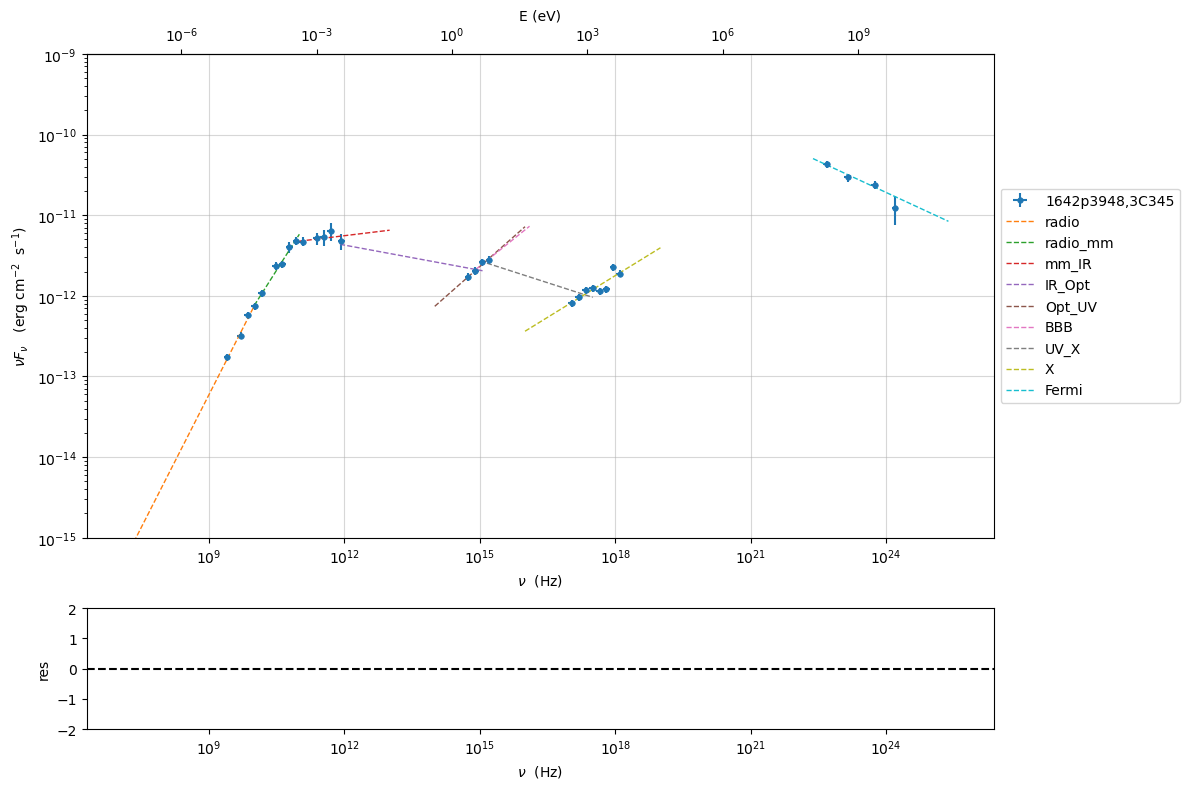

In [9]:
from jetset.sed_shaper import  SEDShape
my_shape=SEDShape(sed_data)
my_shape.eval_indices(silent=True)
p=my_shape.plot_indices()
p.setlim(y_min=1E-15,y_max=1E-9)

for the synchrotron sed_shaping we include the check for Big Blue Bump (BBB) component. Moreover, we force the model to use a pure log-parabolic function and not a log-cubic one in order to get a better estimation of the BBB  component. The fit values of the BBB component will be used in the `ObsConstrain` to guess the accretion disk luminosity and temperature

In [10]:
mm,best_fit=my_shape.sync_fit(check_BBB_template=True,
                              check_host_gal_template=False,
                              use_log_par=True,
                              Ep_start=None,
                              minimizer='lsb',
                              silent=True,
                              fit_range=[9,16])


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [9, 16]
--> class:  LSP

--> class:  LSP




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogParabolaEp,b,-3.083929e-01,-3.083929e-01,2.309292e-02,--,-1.560623e-01,-1.000000e+01,0.000000e+00,False
LogParabolaEp,Ep,1.168757e+01,1.168757e+01,9.352232e-02,--,1.281229e+01,0.000000e+00,3.000000e+01,False
LogParabolaEp,Sp,-1.122282e+01,-1.122282e+01,3.377790e-02,--,-1.089599e+01,-3.000000e+01,0.000000e+00,False
BBB,nuFnu_p_BBB,-1.155675e+01,-1.155675e+01,1.991849e-02,--,-1.089599e+01,-1.289599e+01,-8.895992e+00,False
BBB,nu_scale,9.430361e-03,9.430361e-03,4.189487e-04,--,0.000000e+00,-5.000000e-01,5.000000e-01,False


---> sync       nu_p=+1.168757e+01 (err=+9.352232e-02)  nuFnu_p=-1.122282e+01 (err=+3.377790e-02) curv.=-3.083929e-01 (err=+2.309292e-02)




*** Log-Polynomial fitting of the IC component ***
---> fit range: [16, 26]
---> LogCubic fit
====> simplex
====> migrad
====> simplex
====> migrad
====> simplex
====> migrad




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.239523e-01,-1.239523e-01,1.307983e-02,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-1.215669e-02,-1.215669e-02,2.221392e-03,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,2.238469e+01,2.238469e+01,1.156381e-01,--,2.235747e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.038704e+01,-1.038704e+01,4.359969e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> IC         nu_p=+2.238469e+01 (err=+1.156381e-01)  nuFnu_p=-1.038704e+01 (err=+4.359969e-02) curv.=-1.239523e-01 (err=+1.307983e-02)



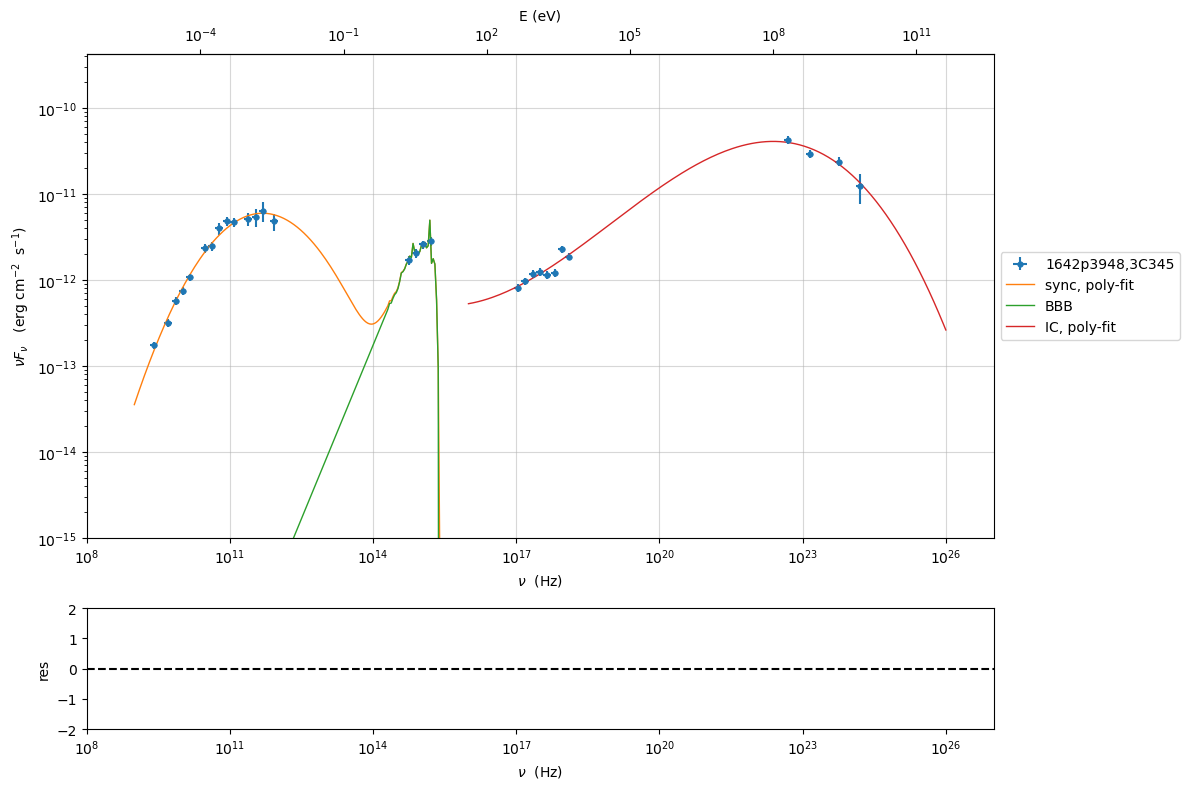

In [11]:
my_shape.IC_fit(fit_range=[16,26],minimizer='minuit', silent=True)
p=my_shape.plot_shape_fit()
p.setlim(y_min=1E-15)

In this case we use the `constrain_SSC_EC_model`, and we ask to use a dusty torus and BLR component external component

In [12]:
from jetset.obs_constrain import ObsConstrain
from jetset.minimizer import fit_SED
sed_obspar=ObsConstrain(B_range=[0.1,0.2],
                        distr_e='bkn',
                        t_var_sec=15*86400,
                        nu_cut_IR=1E9,
                        theta=2,
                        bulk_factor=20,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_EC_model(electron_distribution_log_values=False,EC_components_list=['EC_DT','EC_BLR'],R_H=2E18,silent=True,)



***  constrains parameters from observable ***

===> setting C threads to 12
adding par: L_Disk to  R_BLR_in
==> par R_BLR_in is depending on ['L_Disk'] according to expr:   R_BLR_in =
3E17*(L_Disk/1E46)**0.5
adding par: R_BLR_in to  R_BLR_out
==> par R_BLR_out is depending on ['R_BLR_in'] according to expr:   R_BLR_out =
R_BLR_in*1.1
adding par: L_Disk to  R_DT
==> par R_DT is depending on ['L_Disk'] according to expr:   R_DT =
2E19*(L_Disk/1E46)**0.5


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,7.607512e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,2.000000e+18,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.500000e-01,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True
jet_leptonic,theta,jet-viewing-angle,deg,2.000000e+00,0.000000e+00,9.000000e+01,False,False
jet_leptonic,BulkFactor,jet-bulk-factor,lorentz-factor*,2.000000e+01,1.000000e+00,1.000000e+05,False,False
jet_leptonic,z_cosm,redshift,,5.930000e-01,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.033091e+01,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.311585e+04,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,8.405479e+02,0.000000e+00,--,False,False


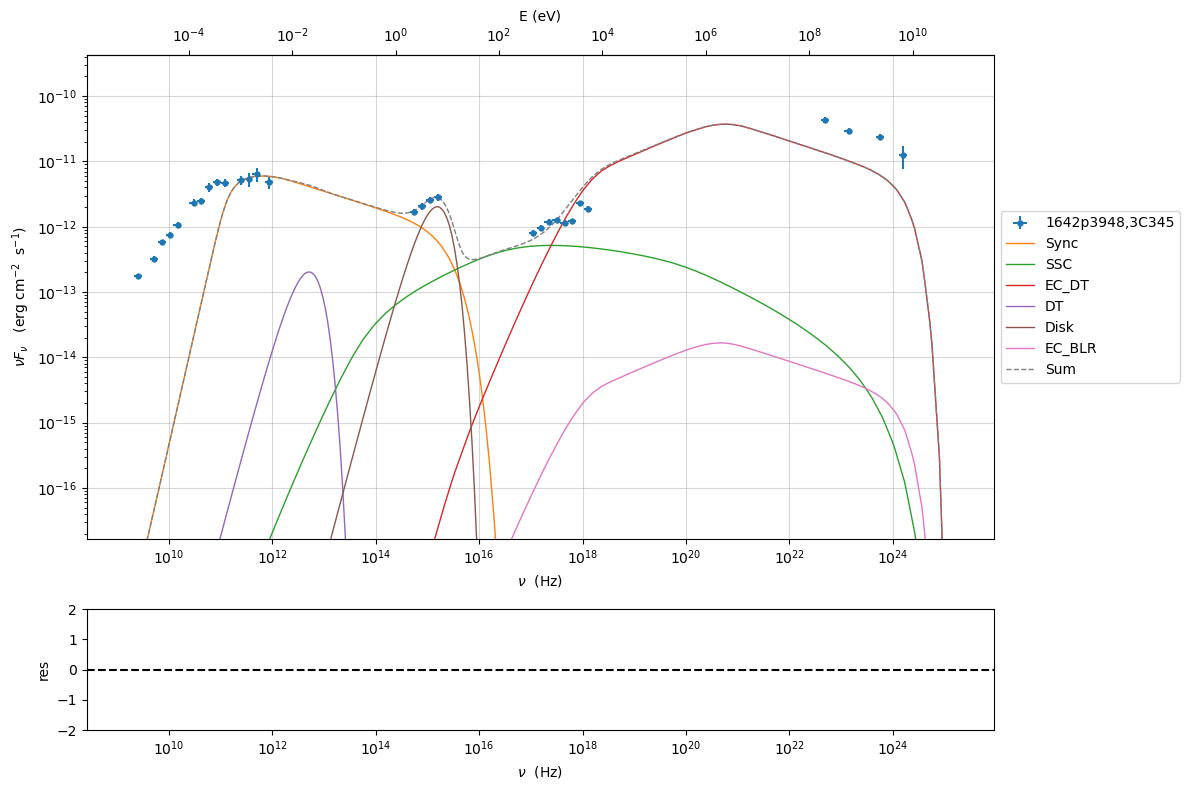

In [13]:
prefit_jet.eval()
p=prefit_jet.plot_model(sed_data=sed_data)

In [14]:
prefit_jet.make_conical_jet(theta_open=5)

adding par: R_H to  R
adding par: theta_open to  R
==> par R is depending on ['R_H', 'theta_open'] according to expr:   R =
np.tan(np.radians(theta_open))*R_H
setting R_H to 8.695425919436543e+17


In [15]:
prefit_jet.set_EC_dependencies()

==> par R_BLR_in is depending on ['L_Disk'] according to expr:   R_BLR_in =
3E17*(L_Disk/1E46)**0.5
==> par R_BLR_out is depending on ['R_BLR_in'] according to expr:   R_BLR_out =
R_BLR_in*1.1
==> par R_DT is depending on ['L_Disk'] according to expr:   R_DT =
2E19*(L_Disk/1E46)**0.5


In [16]:
prefit_jet.set_external_field_transf('disk')

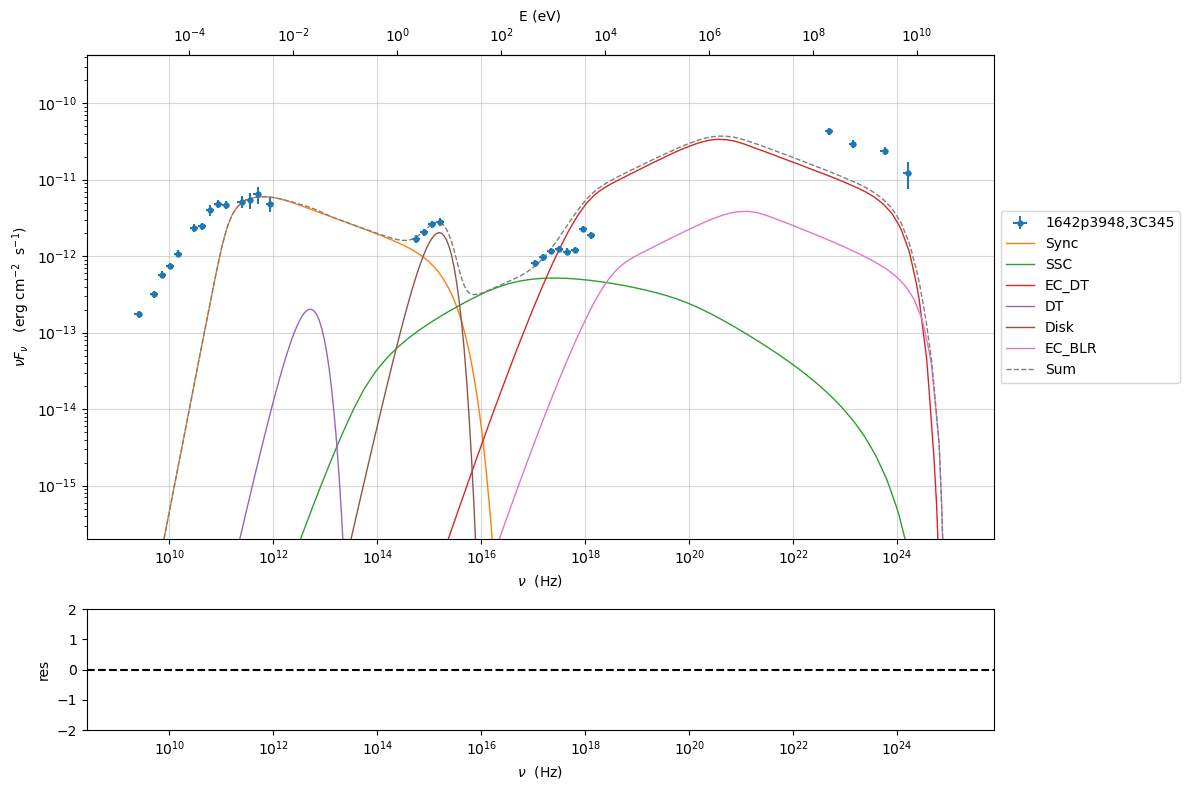

In [17]:
prefit_jet.eval()
p=prefit_jet.plot_model(sed_data=sed_data)
prefit_jet.save_model('prefit_jet_EC.pkl')


The prefit model should works well for the synchrotron component, but the EC one is a bit problematic. We can set as starting values  a slightly harder value of `p`, and a larger value of `gamma_break` and `gmax`. We freeze some parameters, and we also set some `fit_range` values. Setting fit_range can speed-up the fit convergence but should be judged by the user each time according to the physics of the particular source

## EC model fit

In [18]:
from jetset.data_loader import ObsData
sed_data=ObsData.load('3C454_data.pkl')
from jetset.jet_model import Jet

In [19]:
from jetset.model_manager import  FitModel
jet=Jet.load_model('prefit_jet_EC.pkl')
jet.set_gamma_grid_size(100)
fit_model=FitModel( jet=jet, name='EC-best-fit-lsb')
fit_model.show_model_components()

===> setting C threads to 12
adding par: L_Disk to  R_DT
==> par R_DT is depending on ['L_Disk'] according to expr:   R_DT =
2E19*(L_Disk/1E46)**0.5
adding par: L_Disk to  R_BLR_in
==> par R_BLR_in is depending on ['L_Disk'] according to expr:   R_BLR_in =
3E17*(L_Disk/1E46)**0.5
adding par: R_BLR_in to  R_BLR_out
==> par R_BLR_out is depending on ['R_BLR_in'] according to expr:   R_BLR_out =
R_BLR_in*1.1
adding par: R_H to  R
adding par: theta_open to  R
==> par R is depending on ['R_H', 'theta_open'] according to expr:   R =
np.tan(np.radians(theta_open))*R_H

--------------------------------------------------------------------------------
Composite model description
--------------------------------------------------------------------------------
name: EC-best-fit-lsb  
type: composite_model  
components models:
 -model name: jet_leptonic model type: jet

--------------------------------------------------------------------------------


In [20]:

fit_model.freeze('jet_leptonic','z_cosm')
fit_model.freeze('jet_leptonic','theta')

fit_model.free('jet_leptonic','R_H')
fit_model.freeze('jet_leptonic','L_Disk')
fit_model.freeze('jet_leptonic','tau_DT')
fit_model.freeze('jet_leptonic','tau_BLR')

fit_model.jet_leptonic.parameters.R_H.fit_range=[8E17,5E19]
fit_model.jet_leptonic.parameters.T_Disk.fit_range=[1E4,1E5]
fit_model.jet_leptonic.parameters.T_DT.fit_range=[100,1000]
fit_model.jet_leptonic.parameters.gamma_break.fit_range=[100,500]
fit_model.jet_leptonic.parameters.gmin.fit_range=[2,100]
fit_model.jet_leptonic.parameters.gmax.fit_range=[1E4,1E5]
fit_model.jet_leptonic.parameters.B.fit_range=[1E-2,1]
fit_model.jet_leptonic.parameters.p.fit_range=[1,2.5]
fit_model.jet_leptonic.parameters.p_1.fit_range=[3,4]
fit_model.jet_leptonic.parameters.theta_open.fit_range=[4,6]
fit_model.jet_leptonic.parameters.BulkFactor.fit_range=[10,30]

In [21]:
from jetset.minimizer import ModelMinimizer
model_minimizer_lsb=ModelMinimizer('lsb')
best_fit_lsb=model_minimizer_lsb.fit(fit_model,sed_data,3E10,1E29,fitname='EC-best-fit-lsb',repeat=1)

filtering data in fit range = [3.000000e+10,1.000000e+29]
data length 24

*** start fit process ***
----- 


0it [00:00, ?it/s]

- best chisq=1.71336e+02

-------------------------------------------------------------------------
Fit report

Model: EC-best-fit-lsb


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,6.675472e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.581028e+04,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,5.485583e+02,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,1.894755e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,1.588509e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,3.466529e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,T_DT,DT,K,4.502140e+02,0.000000e+00,--,False,False
jet_leptonic,"*R_DT(D,L_Disk)",DT,cm,1.305539e+19,0.000000e+00,--,False,True
jet_leptonic,tau_DT,DT,,1.000000e-01,0.000000e+00,1.000000e+00,False,True
jet_leptonic,tau_BLR,BLR,,1.000000e-01,0.000000e+00,1.000000e+00,False,True



converged=True
calls=633
mesg=


'`ftol` termination condition is satisfied.'

dof=12
chisq=171.335707, chisq/red=14.277976 null hypothesis sig=0.000000

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,6.675472e+00,6.675472e+00,2.084490e+01,--,1.033091e+01,2.000000e+00,1.000000e+02,False
jet_leptonic,gmax,1.581028e+04,1.581028e+04,1.907208e+04,--,1.311585e+04,1.000000e+04,1.000000e+05,False
jet_leptonic,N,5.485583e+02,5.485583e+02,4.158130e+03,--,8.405479e+02,0.000000e+00,--,False
jet_leptonic,gamma_break,1.894755e+02,1.894755e+02,3.075634e+02,--,2.279937e+02,1.000000e+02,5.000000e+02,False
jet_leptonic,p,1.588509e+00,1.588509e+00,2.908949e+00,--,2.309926e+00,1.000000e+00,2.500000e+00,False
jet_leptonic,p_1,3.466529e+00,3.466529e+00,3.550985e-01,--,3.500000e+00,3.000000e+00,4.000000e+00,False
jet_leptonic,T_DT,4.502140e+02,4.502140e+02,3.219246e+03,--,1.000000e+02,1.000000e+02,1.000000e+03,False
jet_leptonic,"*R_DT(D,L_Disk)",1.305539e+19,--,--,--,1.305539e+19,0.000000e+00,--,True
jet_leptonic,tau_DT,1.000000e-01,--,--,--,1.000000e-01,0.000000e+00,1.000000e+00,True
jet_leptonic,tau_BLR,1.000000e-01,--,--,--,1.000000e-01,0.000000e+00,1.000000e+00,True


-------------------------------------------------------------------------




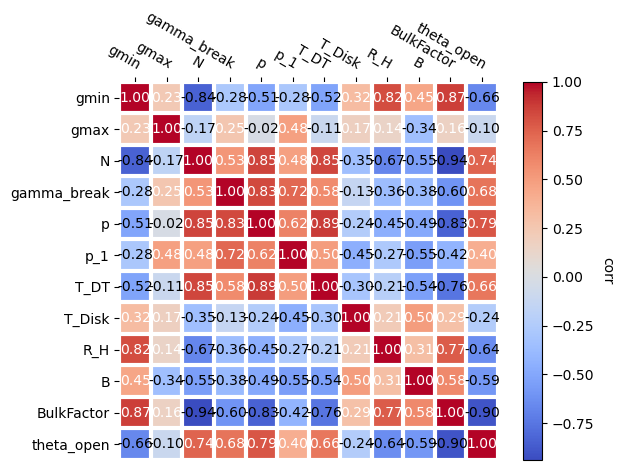

In [22]:
p=model_minimizer_lsb.plot_corr_matrix()

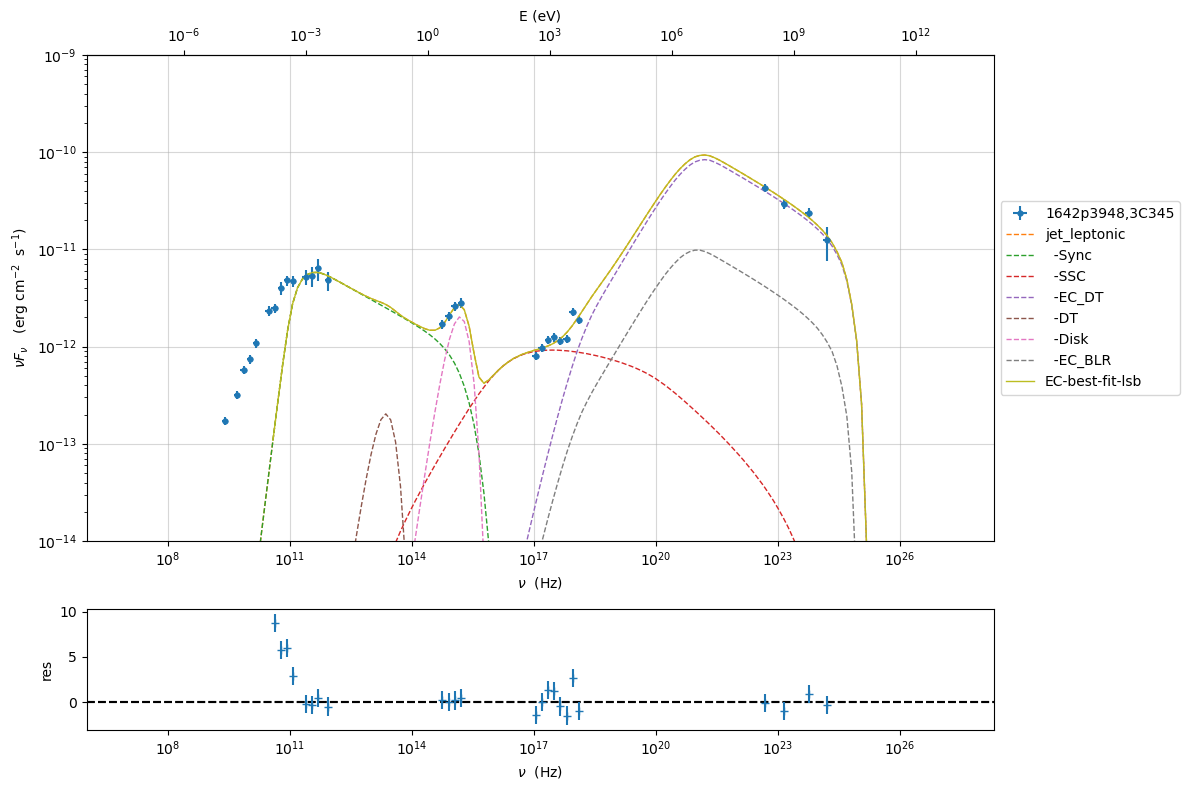

In [23]:
%matplotlib inline
fit_model.set_nu_grid(1E6,1E30,200)
fit_model.eval()
p2=fit_model.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-14,y_max=1E-9,x_min=1E6,x_max=2E28)

In [24]:
from jetset.minimizer import ModelMinimizer
model_minimizer_minuit=ModelMinimizer('minuit')
#fit_model.freeze('jet_leptonic','theta_open')
best_fit_minuit=model_minimizer_minuit.fit(fit_model,sed_data,3E10,1E29,fitname='EC-best-fit-minuit',repeat=2)

filtering data in fit range = [3.000000e+10,1.000000e+29]
data length 24

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

====> simplex
====> migrad
- best chisq=3.21399e+01

fit run: 1
- old chisq=3.21399e+01


0it [00:00, ?it/s]

====> simplex
====> migrad
- best chisq=3.16610e+01

-------------------------------------------------------------------------
Fit report

Model: EC-best-fit-minuit


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,3.893234e+00,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,8.993352e+04,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,9.909851e+01,0.000000e+00,--,False,False
jet_leptonic,gamma_break,turn-over-energy,lorentz-factor*,1.734853e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,p,LE_spectral_slope,,1.274681e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,p_1,HE_spectral_slope,,3.503112e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,T_DT,DT,K,5.893807e+02,0.000000e+00,--,False,False
jet_leptonic,"*R_DT(D,L_Disk)",DT,cm,1.305539e+19,0.000000e+00,--,False,True
jet_leptonic,tau_DT,DT,,1.000000e-01,0.000000e+00,1.000000e+00,False,True
jet_leptonic,tau_BLR,BLR,,1.000000e-01,0.000000e+00,1.000000e+00,False,True



converged=True
calls=1021
mesg=


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 31.66                      │             Nfcn = 1021              │
│ EDM = 0.00019 (Goal: 0.0002)     │           time = 31.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0  │  3.89323  │  0.00023  │            │            │    2    │   100   │       │
│ 1 │ par_1  │89.93352e3 │ 0.00028e3 │            │            │  10000  │ 100000  │       │
│ 2 │ par_2  │  99.0985  │  0.0014   │            │            │    0    │         │       │
│ 3 │ par_3  │ 173.4853  │  0.0017   │            │            │   100   │   500   │       │
│ 4 │ par_4  │ 1.274681  │ 0.000007  │            │            │    1    │   2.5   │       │
│ 5 │ par_5  │3.50311218 │0.00000004 │            │            │    3    │    4    │       │
│ 6 │ par_6  │    589    │    14     │            │            │   100   │  1000   │       │
│ 7 │ par_7  │  27.8e3   │   2.4e3   │            │            │  10000  │ 100000  │       │
│ 8 │ par_8  │3.50970e18 │0.00014e18 │            │            │  8e+17  │  5e+19  │       │
│ 9 │ par_9  │53.1284e-3 │ 0.0027e-3 │            │            │  0.01   │    1    │       │
│ 10│ par_10 │   10.0    │    0.4    │            │            │   10    │   30    │       │
│ 11│ par_11 │ 5.862158  │ 0.000008  │            │            │    4    │    6    │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

dof=12
chisq=31.661039, chisq/red=2.638420 null hypothesis sig=0.001561

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,3.893234e+00,3.893234e+00,2.336607e-04,--,6.675472e+00,2.000000e+00,1.000000e+02,False
jet_leptonic,gmax,8.993352e+04,8.993352e+04,2.756248e-01,--,1.581028e+04,1.000000e+04,1.000000e+05,False
jet_leptonic,N,9.909851e+01,9.909851e+01,1.397515e-03,--,5.485583e+02,0.000000e+00,--,False
jet_leptonic,gamma_break,1.734853e+02,1.734853e+02,1.658699e-03,--,1.894755e+02,1.000000e+02,5.000000e+02,False
jet_leptonic,p,1.274681e+00,1.274681e+00,6.788564e-06,--,1.588509e+00,1.000000e+00,2.500000e+00,False
jet_leptonic,p_1,3.503112e+00,3.503112e+00,3.994333e-08,--,3.466529e+00,3.000000e+00,4.000000e+00,False
jet_leptonic,T_DT,5.893807e+02,5.893807e+02,1.422676e+01,--,4.502140e+02,1.000000e+02,1.000000e+03,False
jet_leptonic,"*R_DT(D,L_Disk)",1.305539e+19,--,--,--,1.305539e+19,0.000000e+00,--,True
jet_leptonic,tau_DT,1.000000e-01,--,--,--,1.000000e-01,0.000000e+00,1.000000e+00,True
jet_leptonic,tau_BLR,1.000000e-01,--,--,--,1.000000e-01,0.000000e+00,1.000000e+00,True


-------------------------------------------------------------------------




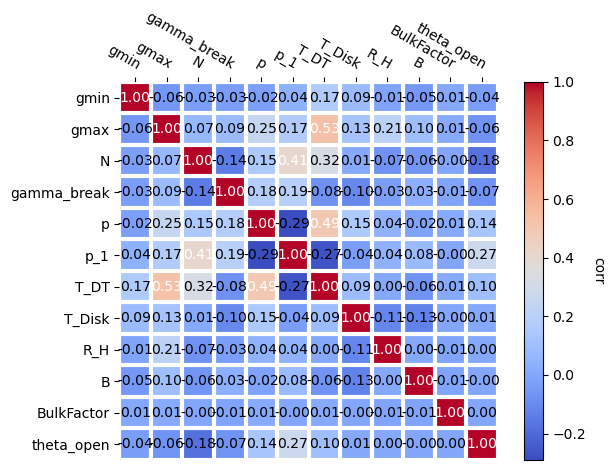

In [25]:
p=model_minimizer_minuit.plot_corr_matrix()

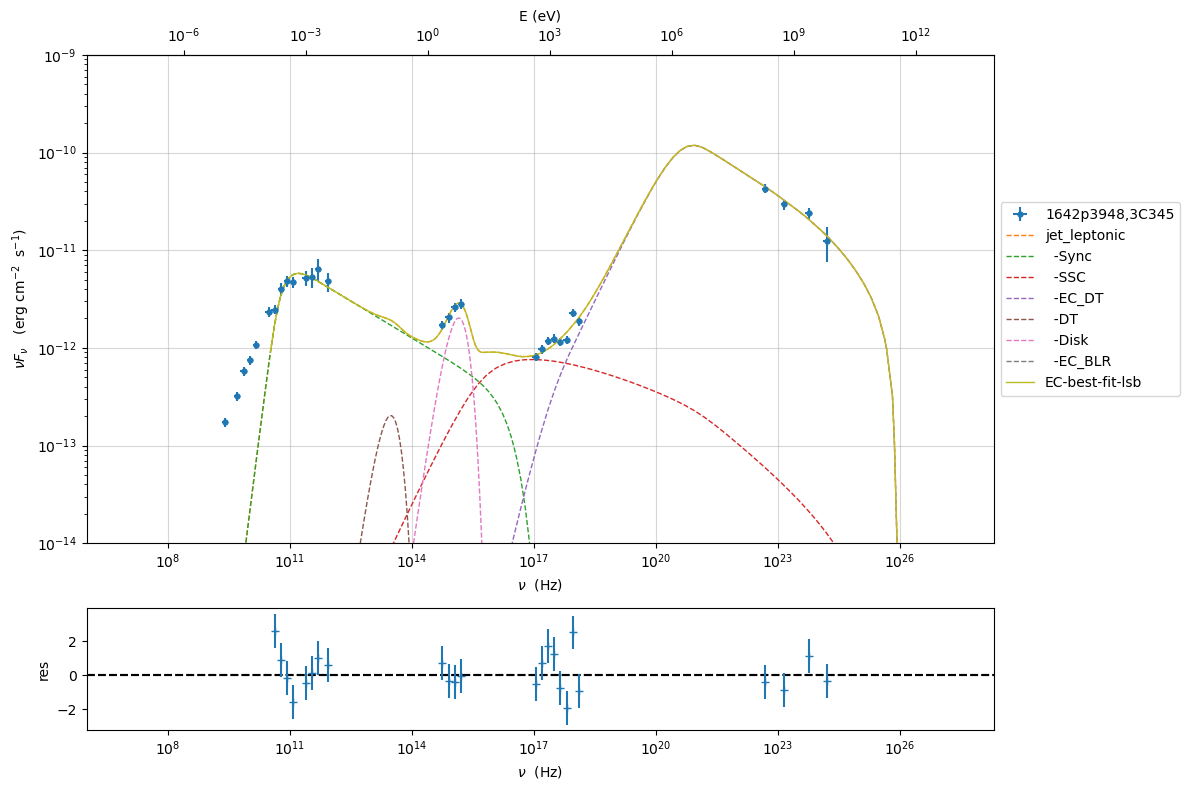

In [26]:
%matplotlib inline
fit_model.set_nu_grid(1E6,1E30,500)
fit_model.eval()
p2=fit_model.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-14,y_max=1E-9,x_min=1E6,x_max=2E28)

In [27]:
jet.energetic_report()

name,type,units,val
BulkLorentzFactor,jet-bulk-factor,,1.000000e+01
U_e,Energy dens. blob rest. frame,erg / cm3,3.869527e-03
U_p_cold,Energy dens. blob rest. frame,erg / cm3,1.489725e-01
U_B,Energy dens. blob rest. frame,erg / cm3,1.123087e-04
U_Synch,Energy dens. blob rest. frame,erg / cm3,9.582487e-06
U_Synch_DRF,Energy dens. disk rest. frame,erg / cm3,9.614802e-01
U_Disk,Energy dens. blob rest. frame,erg / cm3,2.827817e-06
U_BLR,Energy dens. blob rest. frame,erg / cm3,2.188308e-07
U_DT,Energy dens. blob rest. frame,erg / cm3,1.331679e-03
U_CMB,Energy dens. blob rest. frame,erg / cm3,0.000000e+00


In [28]:
best_fit_minuit.save_report('EC-best-fit-minuit.pkl')
model_minimizer_minuit.save_model('EC_model_minimizer_minuit.pkl')
fit_model.save_model('EC_fit_model_minuit.pkl')

## MCMC 

### creating and setting the sampler

In [29]:
from jetset.mcmc import McmcSampler
from jetset.minimizer import ModelMinimizer
model_minimizer_minuit = ModelMinimizer.load_model('EC_model_minimizer_minuit.pkl')


===> setting C threads to 12
adding par: L_Disk to  R_DT
==> par R_DT is depending on ['L_Disk'] according to expr:   R_DT =
2E19*(L_Disk/1E46)**0.5
adding par: L_Disk to  R_BLR_in
==> par R_BLR_in is depending on ['L_Disk'] according to expr:   R_BLR_in =
3E17*(L_Disk/1E46)**0.5
adding par: R_BLR_in to  R_BLR_out
==> par R_BLR_out is depending on ['R_BLR_in'] according to expr:   R_BLR_out =
R_BLR_in*1.1
adding par: R_H to  R
adding par: theta_open to  R
==> par R is depending on ['R_H', 'theta_open'] according to expr:   R =
np.tan(np.radians(theta_open))*R_H


In [30]:
mcmc=McmcSampler(model_minimizer_minuit)


In [31]:
labels=['N','B','BulkFactor','p_1','gamma_break']
model_name='jet_leptonic'
use_labels_dict={model_name:labels}
mcmc.set_labels(use_labels_dict=use_labels_dict)

In [32]:
mcmc.set_bounds(bound=5.0,bound_rel=True)

par: N  best fit value:  99.09851082377608  mcmc bounds: [0, 594.5910649426565]
par: B  best fit value:  0.05312839237542956  mcmc bounds: [0.01, 0.3187703542525773]
par: BulkFactor  best fit value:  10.000000042111171  mcmc bounds: [10, 30]
par: p_1  best fit value:  3.503112178392646  mcmc bounds: [3, 4]
par: gamma_break  best fit value:  173.4853486770854  mcmc bounds: [100, 500]


In [33]:
mcmc.run_sampler(nwalkers=20, burnin=50,steps=500,progress='notebook')

===> setting C threads to 12
adding par: L_Disk to  R_DT
==> par R_DT is depending on ['L_Disk'] according to expr:   R_DT =
2E19*(L_Disk/1E46)**0.5
adding par: L_Disk to  R_BLR_in
==> par R_BLR_in is depending on ['L_Disk'] according to expr:   R_BLR_in =
3E17*(L_Disk/1E46)**0.5
adding par: R_BLR_in to  R_BLR_out
==> par R_BLR_out is depending on ['R_BLR_in'] according to expr:   R_BLR_out =
R_BLR_in*1.1
adding par: R_H to  R
adding par: theta_open to  R
==> par R is depending on ['R_H', 'theta_open'] according to expr:   R =
np.tan(np.radians(theta_open))*R_H
mcmc run starting



  0%|          | 0/500 [00:00<?, ?it/s]

mcmc run done, with 1 threads took 484.08 seconds


In [34]:
print(mcmc.acceptance_fraction)

0.4997


### plotting the model

To plot the sampled model range against the input best-fit model

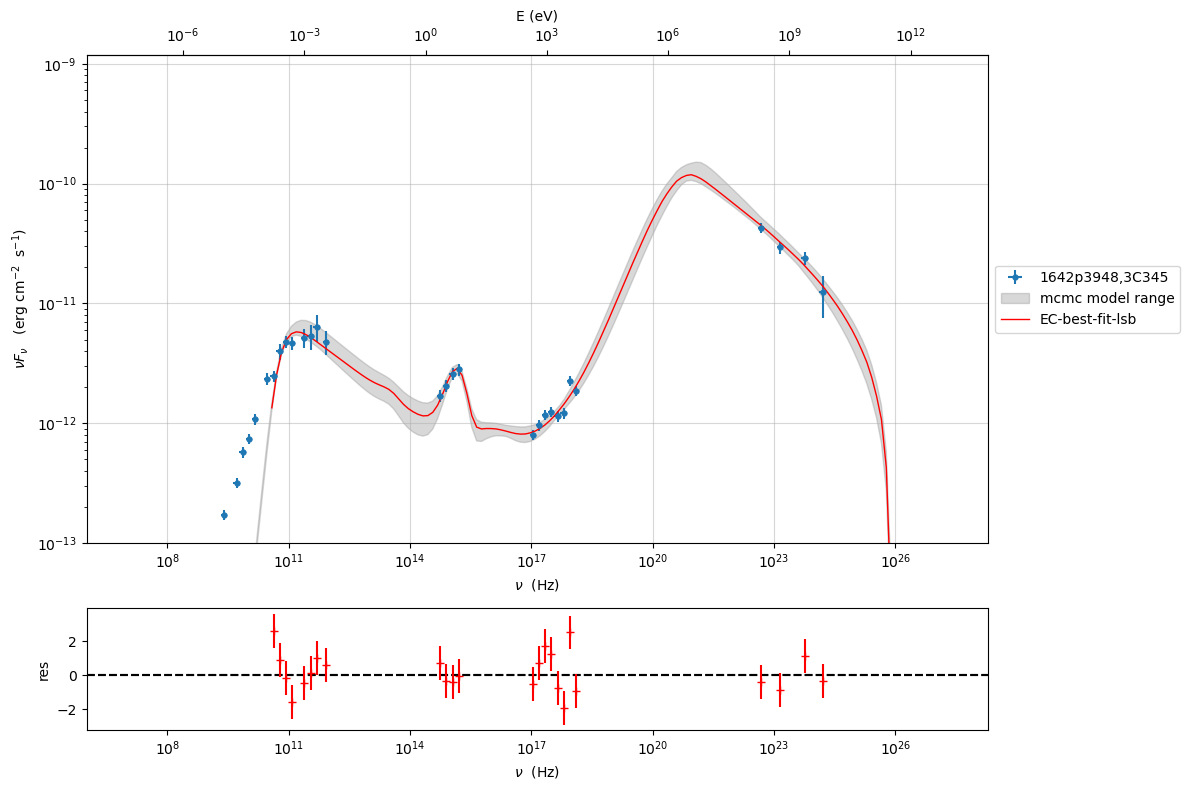

In [35]:
mcmc.model.set_nu_grid(1E6,1E30,200)

p=mcmc.plot_model(sed_data=sed_data,fit_range=[3E10, 1E29],size=100)
p.setlim(y_min=1E-13,x_min=1E6,x_max=2E28)

To plot the sampled model range,providing quantiles, against the input best-fit model, providing quantiles

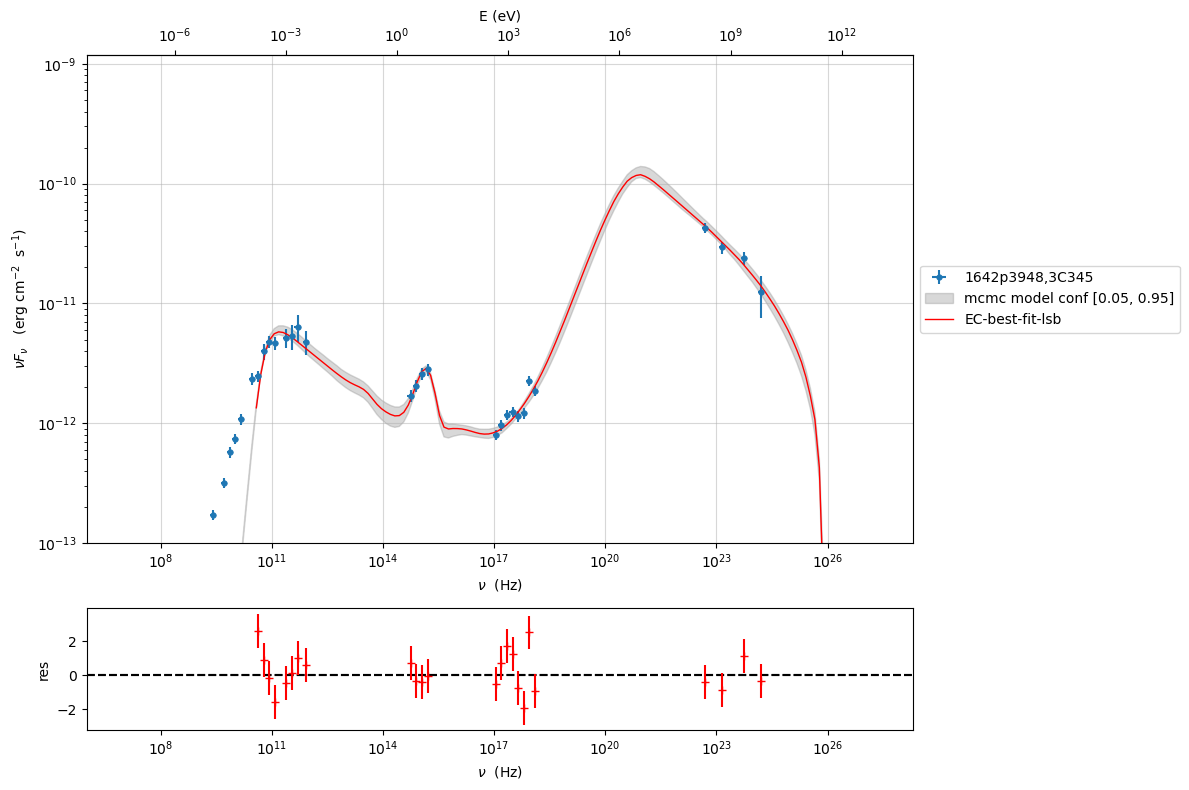

In [36]:
p=mcmc.plot_model(sed_data=sed_data,fit_range=[3E10, 1E29],size=100,quantiles=[0.05,0.95])
p.setlim(y_min=1E-13,x_min=1E6,x_max=2E28)

To plot the sampled model range,providing quantiles, against the  mcmc model at 0.5 quantile (``plot_mcmc_best_fit_model==True`` provides the 0.5 quantile sampled model)

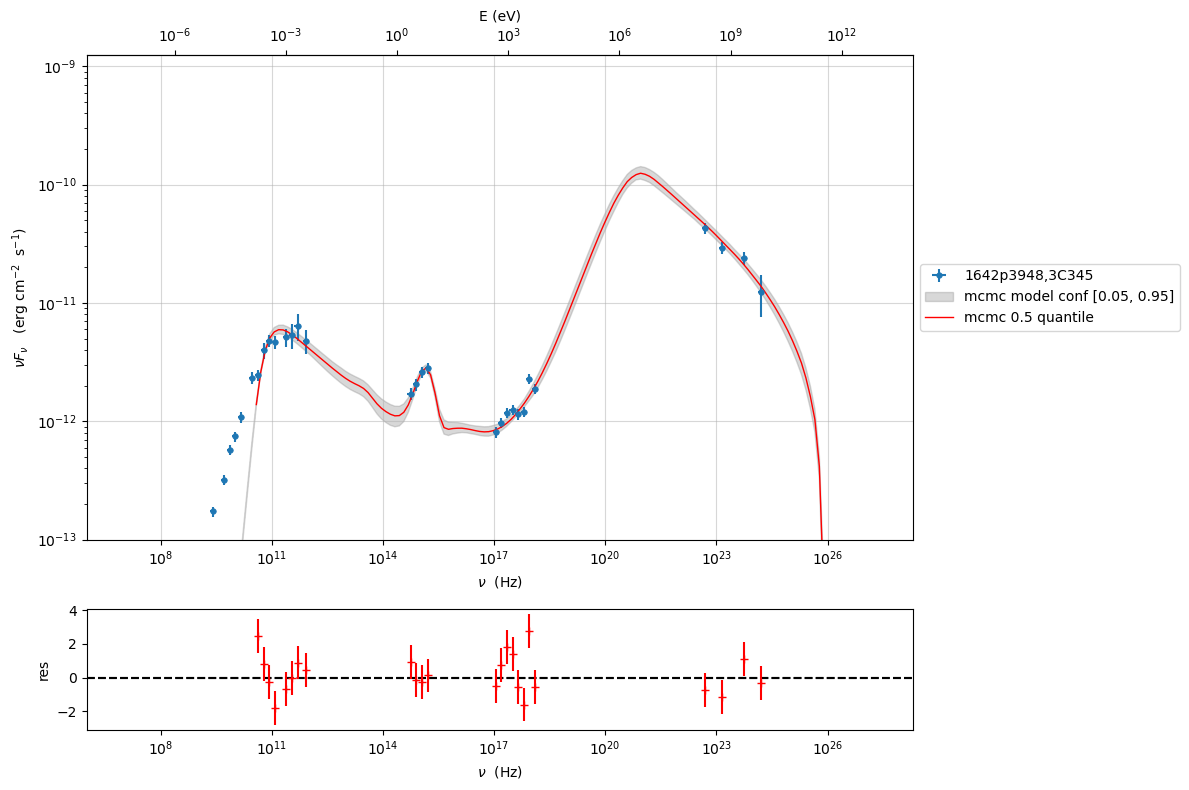

In [38]:
p=mcmc.plot_model(sed_data=sed_data,fit_range=[3E10, 1E29],size=100,quantiles=[0.05,0.95], plot_mcmc_best_fit_model=True)
p.setlim(y_min=1E-13,x_min=1E6,x_max=2E28)

### plotting the posterior corner plot

To have a better rendering on the scatter plot, we redefine the plot labels

In [39]:
mcmc.labels

['N', 'B', 'BulkFactor', 'p_1', 'gamma_break']

In [40]:
mcmc.set_plot_label('N',r'$N$')
mcmc.set_plot_label('B',r'$B$')
mcmc.set_plot_label('BulkFactor',r'$\Gamma$')
mcmc.set_plot_label('p_1',r'$p_1$')
mcmc.set_plot_label('gamma_break',r'$\gamma_{\rm break}$')

the code below lets you tuning the output

1) mpl.rcParams['figure.dpi'] if you increase it you get a better definition
2) title_fmt=".2E" this is the format for python, 2 significant digits, scientific notation
3) title_kwargs=dict(fontsize=12) you can change the fontsize



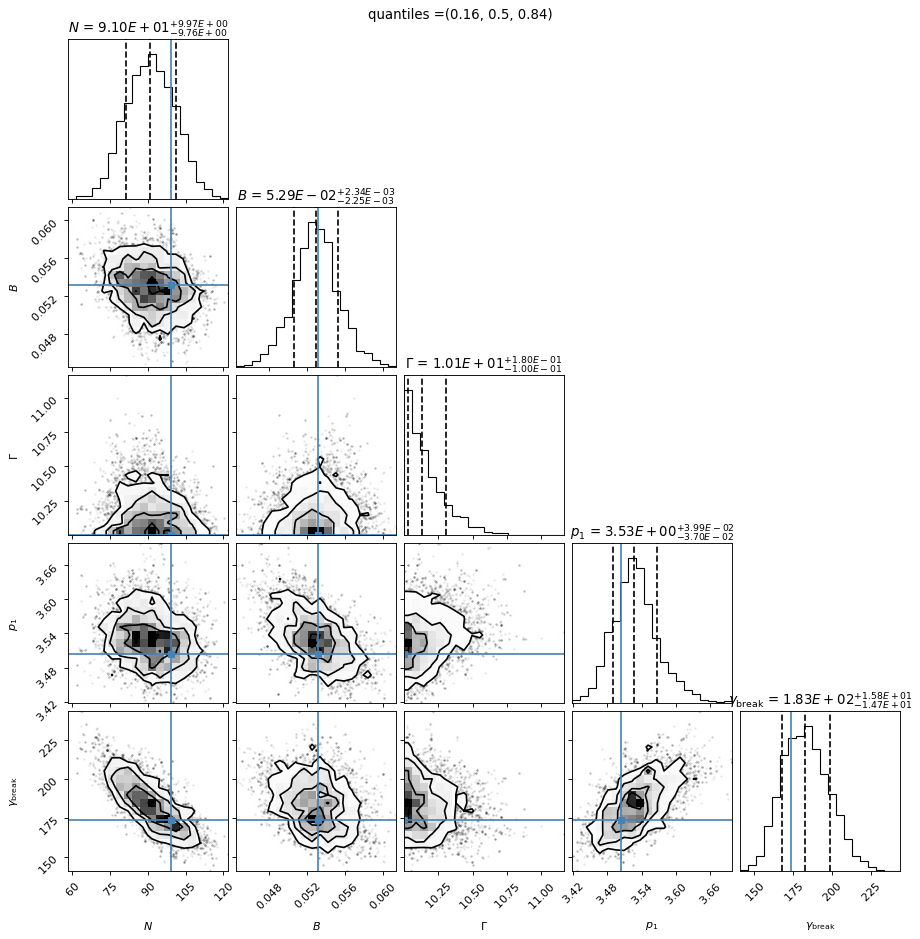

In [41]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 80
f=mcmc.corner_plot(quantiles=(0.16, 0.5, 0.84),title_kwargs=dict(fontsize=12),title_fmt=".2E",use_math_text=True)


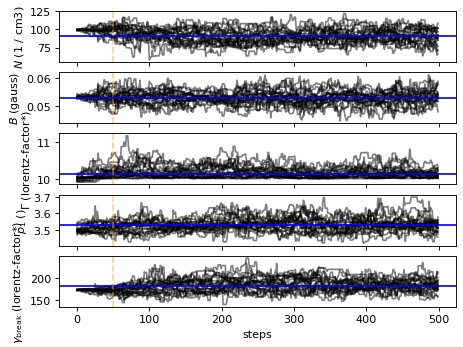

In [42]:
f=mcmc.plot_chain(log_plot=False)

## Save and reuse MCMC

In [43]:
mcmc.save('mcmc_sampler.pkl')

In [44]:
from jetset.mcmc import McmcSampler
from jetset.data_loader import ObsData
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

sed_data=ObsData.load('3C454_data.pkl')

ms=McmcSampler.load('mcmc_sampler.pkl')

===> setting C threads to 12
adding par: L_Disk to  R_DT
==> par R_DT is depending on ['L_Disk'] according to expr:   R_DT =
2E19*(L_Disk/1E46)**0.5
adding par: L_Disk to  R_BLR_in
==> par R_BLR_in is depending on ['L_Disk'] according to expr:   R_BLR_in =
3E17*(L_Disk/1E46)**0.5
adding par: R_BLR_in to  R_BLR_out
==> par R_BLR_out is depending on ['R_BLR_in'] according to expr:   R_BLR_out =
R_BLR_in*1.1
adding par: R_H to  R
adding par: theta_open to  R
==> par R is depending on ['R_H', 'theta_open'] according to expr:   R =
np.tan(np.radians(theta_open))*R_H
===> setting C threads to 12
adding par: L_Disk to  R_DT
==> par R_DT is depending on ['L_Disk'] according to expr:   R_DT =
2E19*(L_Disk/1E46)**0.5
adding par: L_Disk to  R_BLR_in
==> par R_BLR_in is depending on ['L_Disk'] according to expr:   R_BLR_in =
3E17*(L_Disk/1E46)**0.5
adding par: R_BLR_in to  R_BLR_out
==> par R_BLR_out is depending on ['R_BLR_in'] according to expr:   R_BLR_out =
R_BLR_in*1.1
adding par: R_H to  R
a

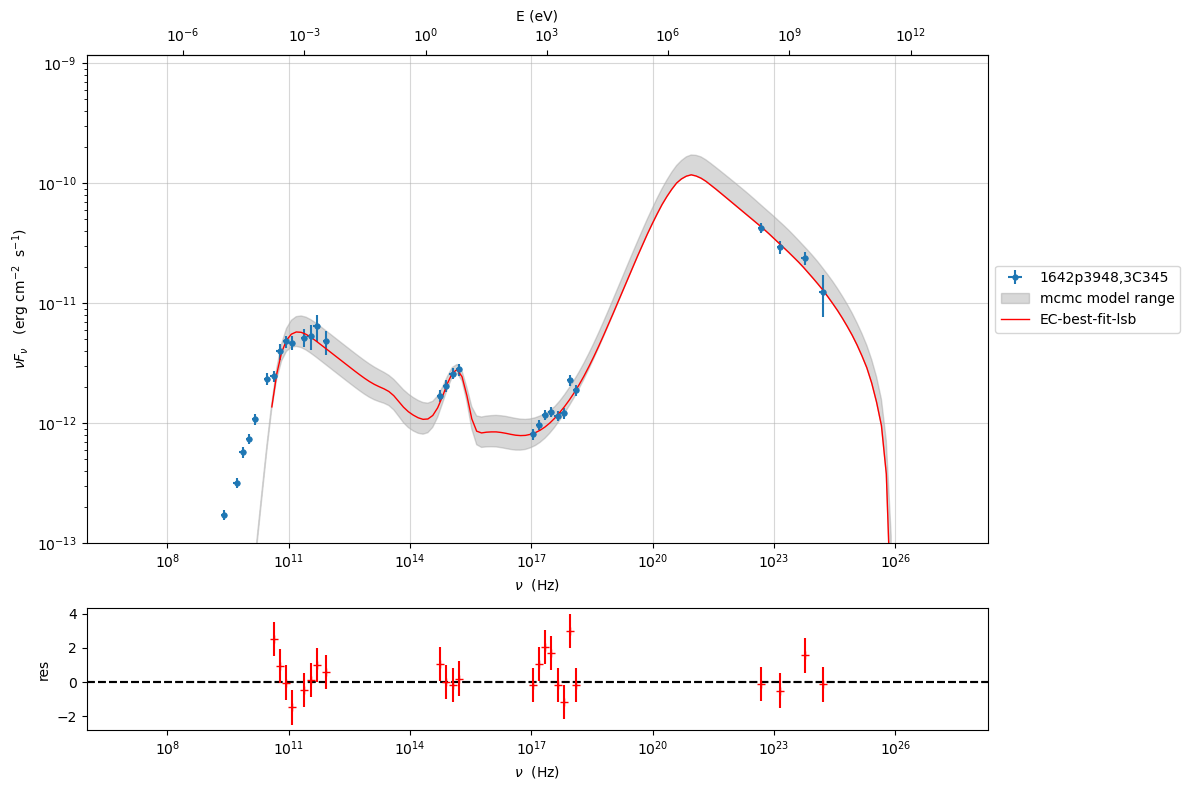

In [45]:
ms.model.set_nu_grid(1E6,1E30,200)

p=ms.plot_model(sed_data=sed_data,fit_range=[3E10, 1E29],size=100)
p.setlim(y_min=1E-13,x_min=1E6,x_max=2E28)

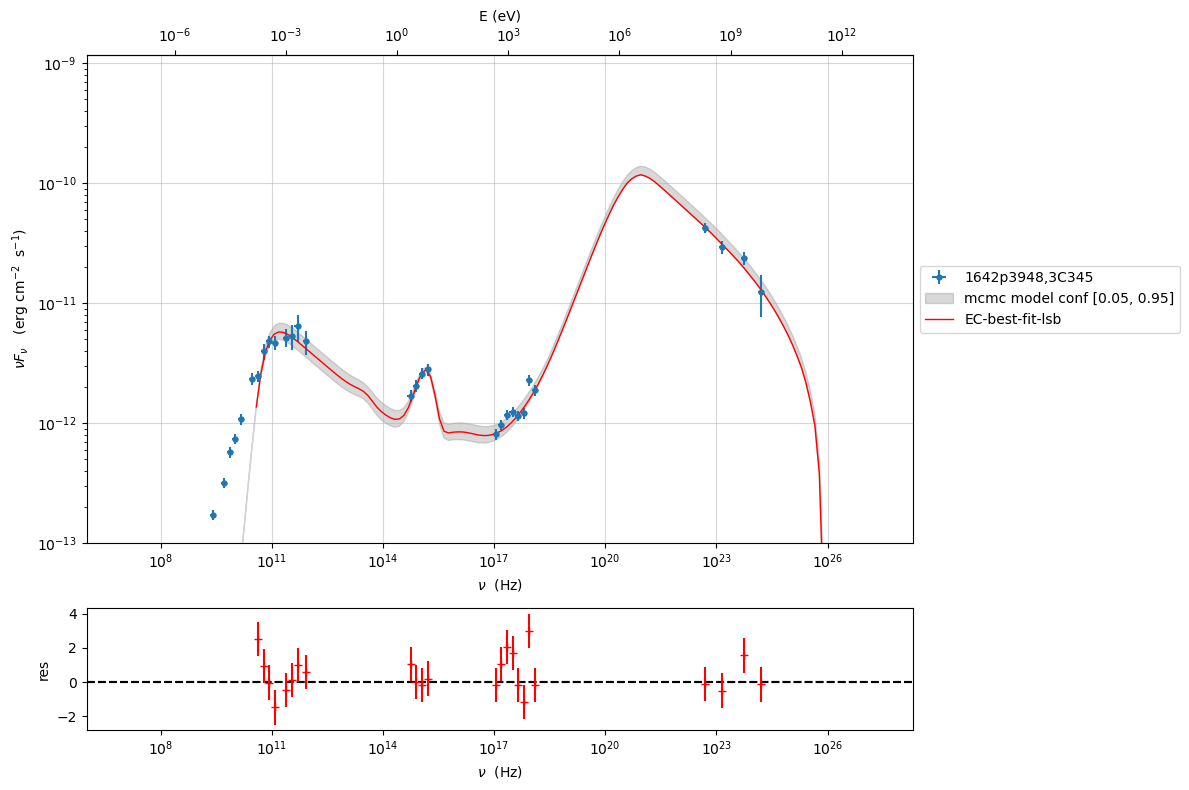

In [46]:
p=ms.plot_model(sed_data=sed_data,fit_range=[3E10, 1E29],size=100,quantiles=[0.05,0.95])
p.setlim(y_min=1E-13,x_min=1E6,x_max=2E28)

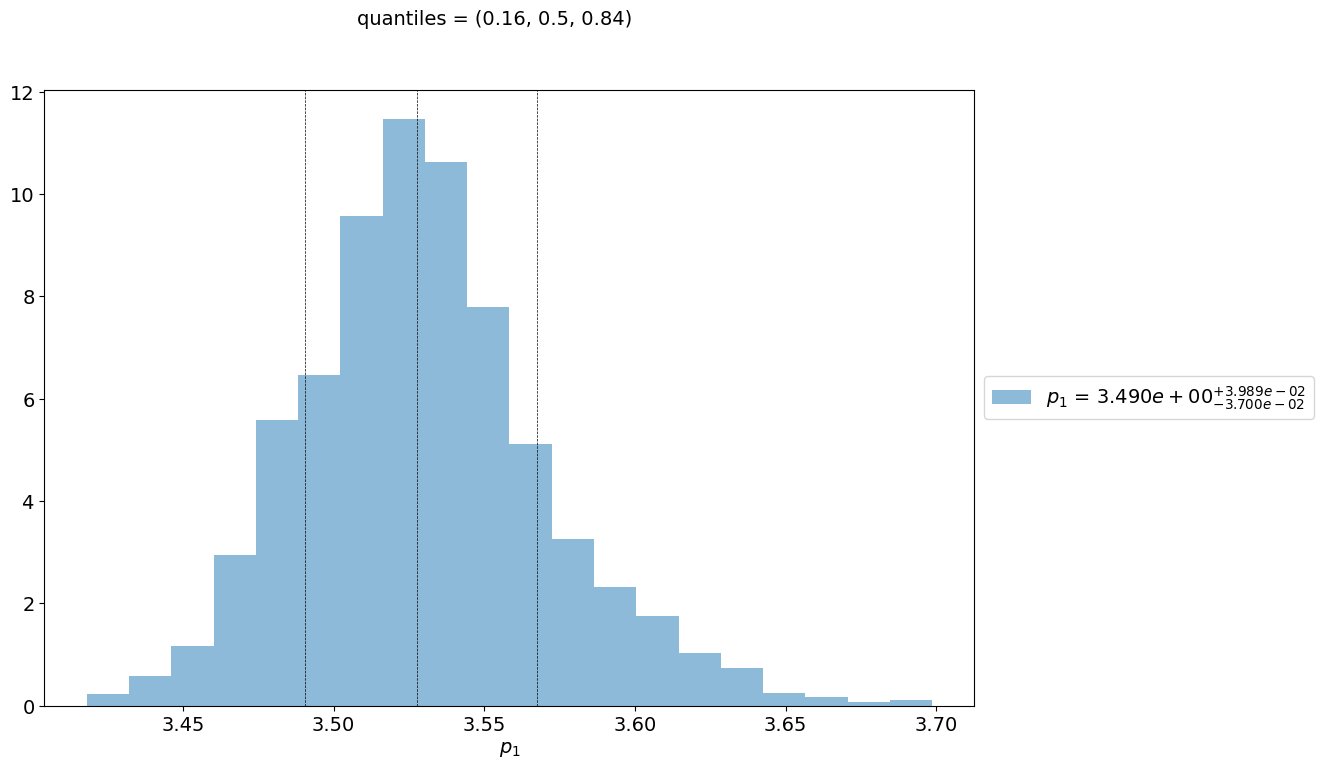

In [47]:
f=ms.plot_par('p_1',log_plot=False)
